In [3]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.evaluate import compute_prdc


from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

**Util function**

In [4]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings[cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes[cov] = len(cov_names)
        else:
            num_classes[cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

## Step 1: Initialize data

In [5]:
dataset_config = {'dataset_path': DATA_DIR / 'processed' / 'dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'conditioning_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': 128}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
scaler = dataset.get_scaler()
n_cat = len(dataset.id2cov["clusters"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


learnt_autoencoder


## Step 2: Initialize encoder

In [6]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        # "dims": [500, 300, 200],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_dentategyrus/fb452d9f-5618-44c8-afa9-a069494a2219/checkpoints/epoch_59.ckpt"
# state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_dentategyrus_200/962aabdd-b098-4e39-a4cf-baf0932b14e9/checkpoints/epoch_59.ckpt"

In [7]:
encoder_model = EncoderModel(in_dim=in_dim,
                              scaler=scaler, 
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initialize FM model

In [8]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5
                        }

In [9]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_dentategyrus/autoencoder_50/checkpoints/last.ckpt")
# ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_dentategyrus_200/2e71c2c5-313f-4be1-9a28-c8126f41c6c2/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [10]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["clusters"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-1.7928,  0.6531,  1.3155,  1.5302, -1.8235, -0.8140,  0.3051, -0.7209,
         -0.2835,  0.9071],
        [ 0.9645, -1.2934, -3.1045,  1.2271,  0.4801,  0.8051, -1.0449, -0.8083,
          0.0043,  0.1158],
        [ 1.5329,  0.7938,  0.1177,  1.1149,  0.4633,  0.0805, -0.4029,  0.7918,
          0.9387, -0.6021],
        [-0.6826, -1.0078,  0.1533,  0.4893, -0.4004,  0.8551,  0.4041,  0.7106,
         -0.0724,  0.4754],
        [ 1.4250, -0.4451,  1.4757, -1.5549,  0.8995, -1.3115, -2.5825,  1.9529,
         -0.2748,  0.4666],
        [-1.0867,  2.1472,  0.0960, -0.6280, -2.0141, -1.2750,  0.6381,  0.9522,
         -1.4439,  0.4950],
        [-0.6424,  1.3045,  0.1343, -0.7747,  1.2901,  0.2080,  0.6055,  0.8936,
          2.0873, -1.1441],
        [-0.8934, -0.0956, -0.1862, -0.1039, -0.9461, -1.5658, -1.1138, -0.3846,
          2.0116,  0.7473],
        [ 0.6323, -0.7117,  0.6097, -0.2861, -0.0626,  0.1928, -0.4601,  0.0864,
         -0.3969, -0.3656

Initializations

In [11]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            scaler=scaler,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=2000, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          

**Check the data**

In [12]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
X = torch.tensor(adata_original.layers["X_counts"].todense())

**Collect checkpoints and run**

General conditional

In [13]:
num_indices = 18000
index_range = len(X)

# Generate random dummy indices without replacement
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

classes_str =  list(adata_indices.obs.clusters)
classes = torch.tensor([dataset.id2cov["clusters"][c] for  c in classes_str]).cuda()
# classes = torch.tensor([dataset.id2cov["clusters"][c] for  c in classes])

log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()
# log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1)))

In [14]:
X_generated = generative_model.batched_sample(batch_size=180,
                                                repetitions=100,
                                                n_sample_steps=2, 
                                                covariate="clusters", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

X_generated = X_generated.to("cpu")

Single condition

In [15]:
dataset.id2cov["clusters"]

{'CA': 0,
 'CA1-Sub': 1,
 'CA2-3-4': 2,
 'GlialProg': 3,
 'Granule': 4,
 'ImmAstro': 5,
 'ImmGranule1': 6,
 'ImmGranule2': 7,
 'Nbl1': 8,
 'Nbl2': 9,
 'OPC': 10,
 'RadialGlia': 11,
 'RadialGlia2': 12,
 'nIPC': 13}

In [16]:
# # Pick condition 
# condition_name = "ImmAstro"
# condition_val = dataset.id2cov["clusters"][condition_name]
# adata_cond = adata_original[adata_original.obs.clusters==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()

# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [17]:
# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="clusters", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=None)

# X_generated = X_generated.to("cpu")

**Create adata and check plots**

In [18]:
adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated).cpu().numpy()))

In [19]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

In [20]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)
adata_generated.obs["classes"] = classes.cpu().numpy()
adata_generated.obs["classes"] = adata_generated.obs["classes"].astype("category")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


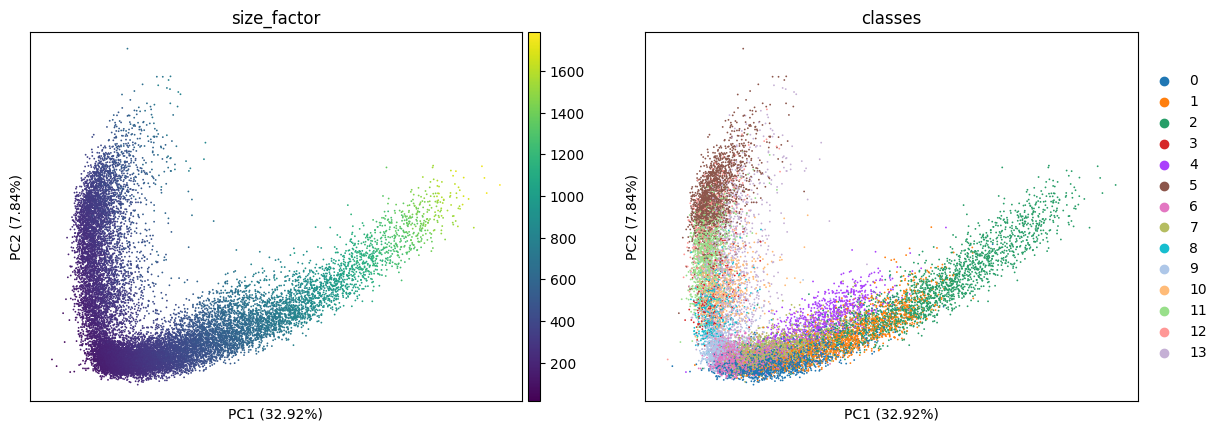

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


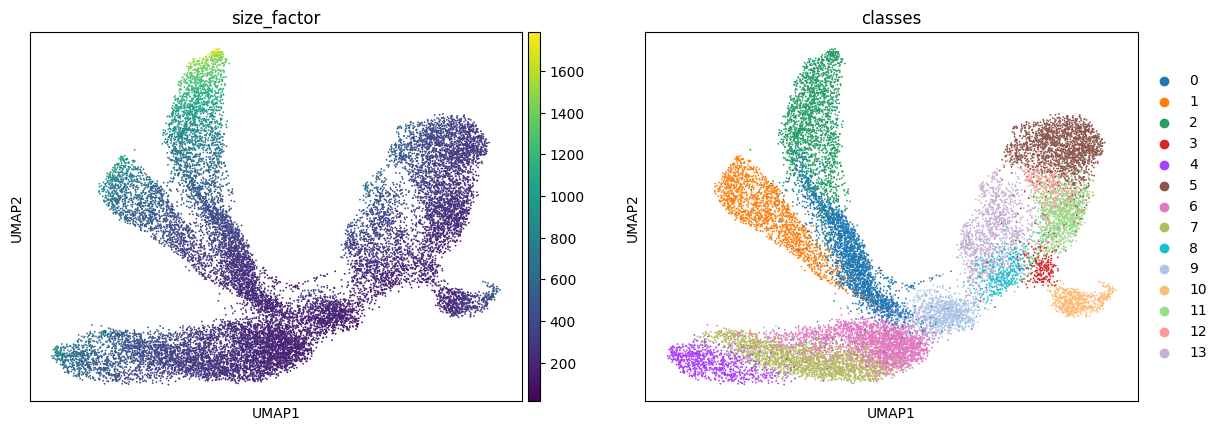

In [21]:
sc.pl.pca(adata_generated, color=["size_factor", "classes"], annotate_var_explained=True)
sc.pl.umap(adata_generated, color=["size_factor", "classes"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


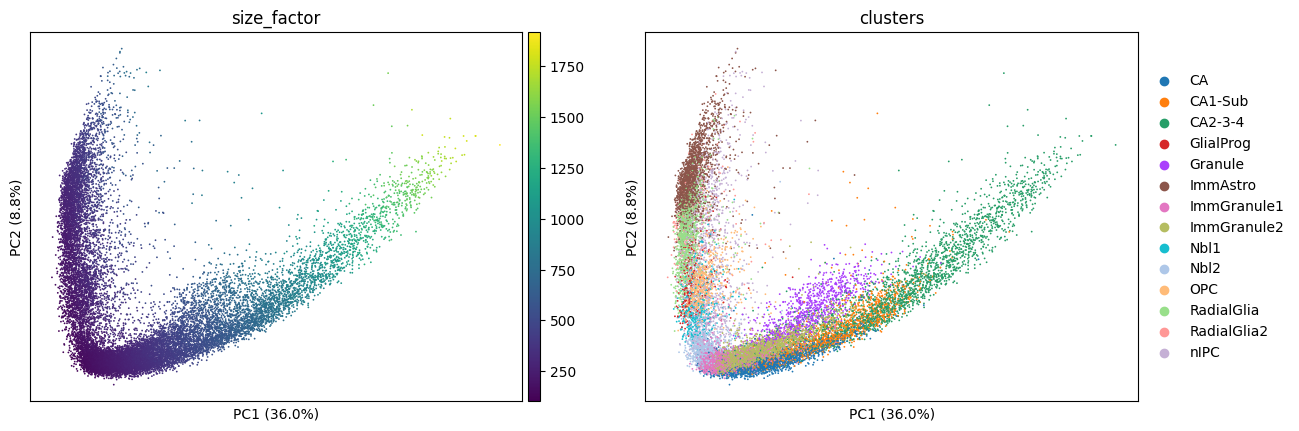

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


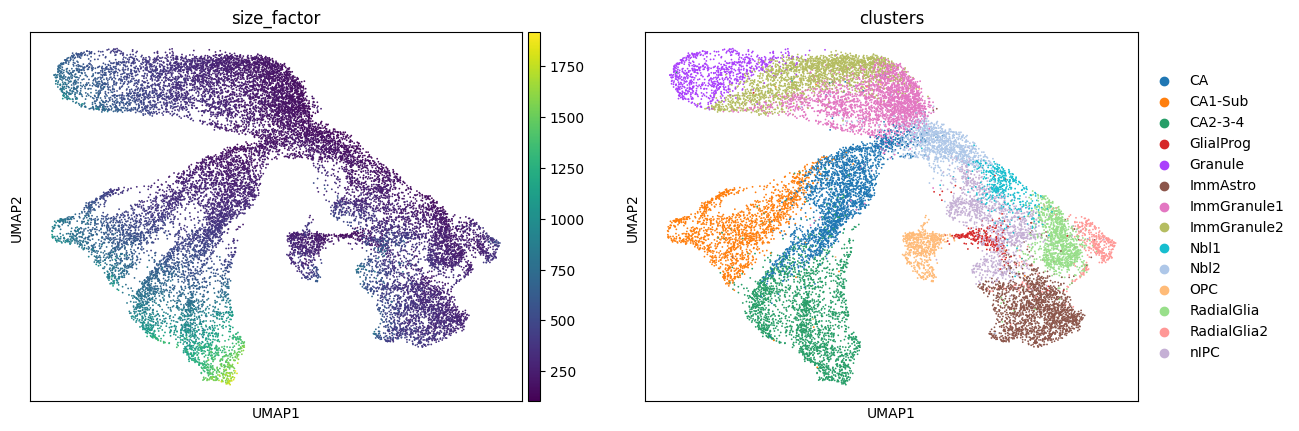

In [22]:
sc.pl.pca(adata_original, color=["size_factor", "clusters"],  annotate_var_explained=True)
sc.pl.umap(adata_original, color=["size_factor", "clusters"])

Merge and plot the generated and real data

In [23]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["classes"] = list(adata_original.obs.clusters)+list(classes_str)

In [25]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [26]:
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


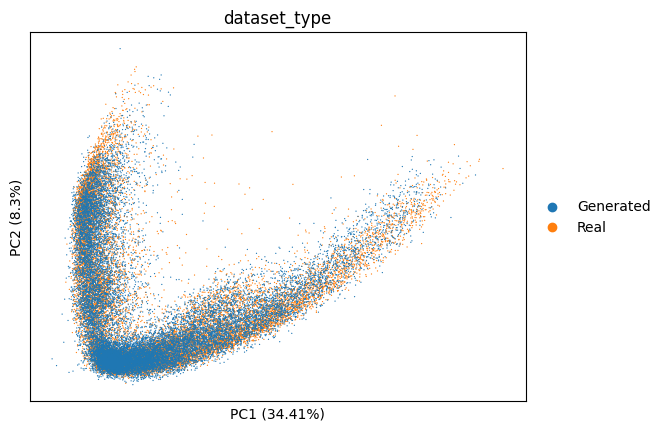

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

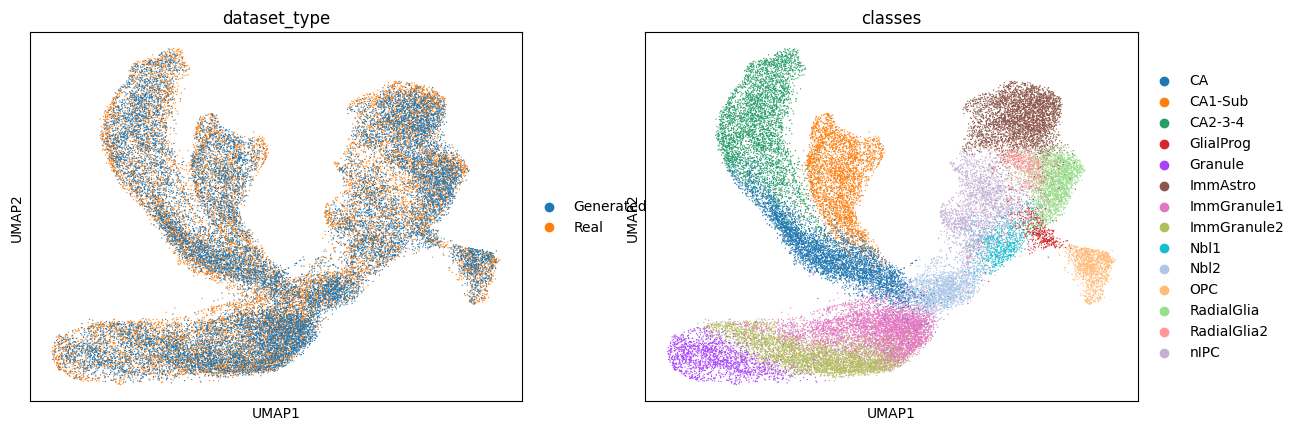

In [27]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color=["dataset_type", "classes"])